In [14]:
import os

## Stupid boilerplate to get GPU acceleration working with abtem and cupy --- IGNORE ---
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".95"
os.environ["CUDA_HOME"] = "/usr/local/cuda-12.6"
os.environ["CUPY_NVRTC_INCLUDE_DIR"] = "/usr/local/cuda-12.6/include"
os.environ["PATH"] = os.environ["CUDA_HOME"] + "/bin:" + os.environ.get("PATH", "")
os.environ["LD_LIBRARY_PATH"] = os.environ["CUDA_HOME"] + "/lib64:" + os.environ.get("LD_LIBRARY_PATH", "")

from PIL import Image
import abtem
import numpy as np
from ase.build import bulk, surface

%matplotlib widget

abtem.config.set({"device": "gpu"})
abtem.config.set({"precision": "float32"})

In [15]:

# Si(111) crystal structure
a = 5.431
si = bulk("Si", "diamond", a=a)
slab = surface(si, (1, 1, 1), layers=6, vacuum=0.0)
slab = abtem.orthogonalize_cell(slab)
slab.pbc = (True, True, True)

# Simulation box: 50 Å lateral, 150 nm thickness
target_xy = 50.0
target_z = 1500.0

Lx, Ly, Lz = slab.cell.lengths()
nx = int(np.ceil(target_xy / Lx))
ny = int(np.ceil(target_xy / Ly))
nz = int(np.ceil(target_z / Lz))

atoms = slab * (nx, ny, nz)
atoms.pbc = (True, True, False)
atoms.center(axis=2)

# Frozen phonon parameters: <u^2> = 0.0045 Å^2
sigma = np.sqrt(0.0045)
slice_thickness_A = 4.7

def make_potential(num_configs):
    frozen = abtem.FrozenPhonons(
        atoms,
        num_configs=num_configs,
        sigmas=sigma,
        directions="xyz",
        ensemble_mean=True,
        seed=0,
    )
    pot = abtem.Potential(
        frozen,
        gpts=(512, 512),
        slice_thickness=slice_thickness_A,
        parametrization="lobato",
        projection="finite",
        periodic=True,
    )
    return pot

# Probe: 200 keV, 6.6 mrad convergence
alpha_mrad = 6.6
probe = abtem.Probe(energy=200e3, semiangle_cutoff=alpha_mrad, soft=0.0, tilt=(0.0, 0.0))

# Detector: 90 mrad max angle
det_max_angle_mrad = 90.0
det = abtem.PixelatedDetector(max_angle=det_max_angle_mrad)

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def to_intensity(meas, gamma=0.15):
    """Convert measurement to intensity with power-law normalization."""
    if getattr(meas, "is_lazy", False):
        meas = meas.compute()
    
    arr = meas.array
    if getattr(meas, "is_complex", False):
        I = np.abs(arr) ** 2
    else:
        I = np.asarray(arr)
    
    I = I / (I.max() + 1e-30)
    I = I ** gamma
    
    if hasattr(meas, "angular_coordinates"):
        ax_mrad, ay_mrad = meas.angular_coordinates
        extent = [ax_mrad.min(), ax_mrad.max(), ay_mrad.min(), ay_mrad.max()]
    else:
        extent = None
    
    return I.T, extent

In [6]:
num_frozen_configs = 32
pot = make_potential(num_configs=num_frozen_configs)
probe.grid.match(pot)
dp = probe.multislice(pot, detectors=det)
dp = dp.compute() 


tasks:   0%|          | 0/130 [00:00<?, ?it/s]

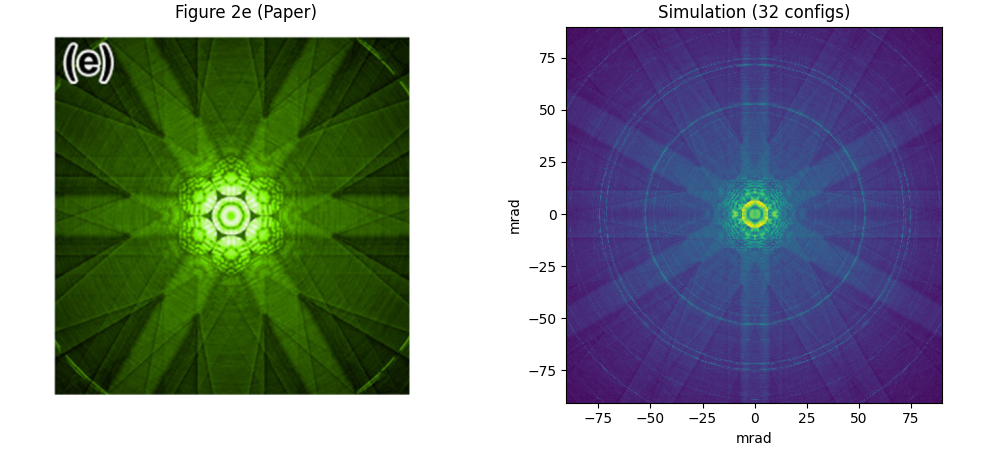

In [ ]:
I_power_law, extent = to_intensity(dp, gamma=0.15)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5), constrained_layout=True)

# Left: Reference Figure 2e from paper
ref_path = "figure2e.png"
if os.path.exists(ref_path):
    img = Image.open(ref_path)
    ax1.imshow(img)
    ax1.axis('off')
    ax1.set_title("Figure 2e (Paper)")
else:
    ax1.text(0.5, 0.5, 'Reference image\nnot found', ha='center', va='center', transform=ax1.transAxes)
    ax1.set_title("Figure 2e (Paper)")

# Right: Simulation result
ax2.imshow(I_power_law, extent=extent, origin="lower", aspect="equal")
ax2.set_xlabel("mrad")
ax2.set_ylabel("mrad")
ax2.set_title(f"Simulation ({num_frozen_configs} configs)")

plt.show()